In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
from os import listdir
from os.path import isfile, join

import pprint
import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageColor, ImageFont
from tqdm.auto import tqdm

import torch
import torchvision
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks
plt.rcParams["savefig.bbox"] = 'tight'

plt.style.use('seaborn-white')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
def load_annotation(label_path, image_key):
    with open(join(label_path, '{:s}.json'.format(image_key)), 'r') as fid:
        anno = json.load(fid)
    return anno

In [4]:
data_dir = '/data/shared/mtsd_v2_fully_annotated/'
img_path = join(data_dir, 'train')
label_path = join(data_dir, 'annotations')

filenames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
np.random.shuffle(filenames)

color = 'red'
alpha = 125
try:
    font = ImageFont.truetype('arial.ttf', 15)
except:
    print('Falling back to default font...')
    font = ImageFont.load_default()

images = []
for i, filename in enumerate(filenames):
    img = Image.open(join(img_path, filename))
#     img = np.array(img)
#     bbox = load_annotation(label_path, filenames.split('.')[0])['objects']['bbox']
#     x1, y1 = bbox['xmin'], bbox['ymin']
#     x2, y2 = bbox['xmax'], bbox['ymax']
    anno = load_annotation(label_path, filename.split('.')[0])
    
    img = img.convert('RGBA')
    img_draw = ImageDraw.Draw(img)

    rects = Image.new('RGBA', img.size)
    rects_draw = ImageDraw.Draw(rects)

    for obj in anno['objects']:
        x1 = obj['bbox']['xmin']
        y1 = obj['bbox']['ymin']
        x2 = obj['bbox']['xmax']
        y2 = obj['bbox']['ymax']

        color_tuple = ImageColor.getrgb(color)
        if len(color_tuple) == 3:
            color_tuple = color_tuple + (alpha,)
        else:
            color_tuple[-1] = alpha

        rects_draw.rectangle((x1+1, y1+1, x2-1, y2-1), fill=color_tuple)
        img_draw.line(((x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)), fill='black', width=1)

        class_name = obj['label']
        img_draw.text((x1 + 5, y1 + 5), class_name, font=font)

    img = Image.alpha_composite(img, rects)
    images.append(img)
    if len(images) == 4:
        break


Falling back to default font...


In [5]:
import pandas as pd 

data = pd.read_csv('/data/shared/mtsd_v2_fully_annotated/traffic_sign_dimension.csv') 
data

,label,id,shape,width,height
0,warning--added-lane-right--g1,w4-3,diamond,36.0,36.0
1,warning--bicycles-crossing--g2,w11-1,diamond,36.0,36.0
2,warning--bicycles-crossing--g3,NaN,diamond,36.0,36.0
3,warning--bus-stop-ahead--g3,NaN,diamond,36.0,36.0
4,warning--children--g2,NaN,diamond,36.0,36.0
...,...,...,...,...,...
101,regulatory--turn-left--g2,r3-5,rect,30.0,36.0
102,regulatory--turn-right--g3,r3-5,rect,30.0,36.0
103,regulatory--wrong-way--g1,r5-1a,rect,42.0,30.0
104,warning--school-zone--g2,s1-1,pentagon,36.0,36.0


In [6]:
selected_labels = ['octagon,36,36', 'diamond,36,36', 'pentagon,36,36', 'rect,36,48', 'rect,30,36']

grouped_labels = {}
with open('/data/shared/mtsd_v2_fully_annotated/traffic_sign_dimension.csv', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        for group, selected_label in enumerate(selected_labels):
            if selected_label in line:
                if group in grouped_labels:
                    grouped_labels[group].append(line.split(',')[0])
                else:
                    grouped_labels[group] = [line.split(',')[0]]
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(grouped_labels)

{   0: ['regulatory--stop--g1'],
    1: [   'warning--added-lane-right--g1',
           'warning--bicycles-crossing--g2',
           'warning--bicycles-crossing--g3',
           'warning--bus-stop-ahead--g3',
           'warning--children--g2',
           'warning--crossroads--g3',
           'warning--curve-left--g2',
           'warning--curve-right--g2',
           'warning--dip--g2',
           'warning--divided-highway-ends--g1',
           'warning--divided-highway-ends--g2',
           'warning--domestic-animals--g3',
           'warning--double-curve-first-left--g2',
           'warning--double-curve-first-right--g2',
           'warning--double-turn-first-right--g1',
           'warning--emergency-vehicles--g1',
           'warning--equestrians-crossing--g2',
           'warning--falling-rocks-or-debris-right--g2',
           'warning--falling-rocks-or-debris-right--g4',
           'warning--hairpin-curve-left--g1',
           'warning--height-restriction--g2',
           'war

In [7]:
mtsd_label_to_shape_index = {}
for key in grouped_labels:
    for sign in grouped_labels[key]:
        mtsd_label_to_shape_index[sign] = key
mtsd_label_to_shape_index

{'warning--added-lane-right--g1': 1,
 'warning--bicycles-crossing--g2': 1,
 'warning--bicycles-crossing--g3': 1,
 'warning--bus-stop-ahead--g3': 1,
 'warning--children--g2': 1,
 'warning--crossroads--g3': 1,
 'warning--curve-left--g2': 1,
 'warning--curve-right--g2': 1,
 'warning--dip--g2': 1,
 'warning--divided-highway-ends--g1': 1,
 'warning--divided-highway-ends--g2': 1,
 'warning--domestic-animals--g3': 1,
 'warning--double-curve-first-left--g2': 1,
 'warning--double-curve-first-right--g2': 1,
 'warning--double-turn-first-right--g1': 1,
 'warning--emergency-vehicles--g1': 1,
 'warning--equestrians-crossing--g2': 1,
 'warning--falling-rocks-or-debris-right--g2': 1,
 'warning--falling-rocks-or-debris-right--g4': 1,
 'warning--hairpin-curve-left--g1': 1,
 'warning--height-restriction--g2': 1,
 'warning--horizontal-alignment-left--g1': 1,
 'warning--horizontal-alignment-right--g1': 1,
 'warning--junction-with-a-side-road-acute-left--g1': 1,
 'warning--junction-with-a-side-road-acute-ri

In [8]:
len(selected_labels)

5

In [9]:
# no need to run again since dataset has already been created and saved in /data/shared/...

for split in ['train', 'val']:
    qqq
    data_dir = '/data/shared/mtsd_v2_fully_annotated/'
    img_path = join(data_dir, split)
    label_path = join(data_dir, 'annotations')

    image_keys = []
    for entry in os.scandir(img_path):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            image_keys.append(entry.name.split('.jpg')[0])

#     for image_key in tqdm(image_keys):
    for image_key in tqdm(image_keys[5000:]):

        anno = load_annotation(label_path, image_key)

        with Image.open(os.path.join(img_path, '{:s}.jpg'.format(image_key))) as img:
            img = img.convert('RGBA')
        for obj in anno['objects']:
            class_name = obj['label']

            if class_name not in mtsd_label_to_shape_index:
                # (k+1)th label
                shape_index = len(selected_labels)
#                 continue
            else:
                shape_index = mtsd_label_to_shape_index[class_name]
                    
            x1 = obj['bbox']['xmin']
            y1 = obj['bbox']['ymin']
            x2 = obj['bbox']['xmax']
            y2 = obj['bbox']['ymax']
            
            box_length = 1.1 * max((x2 - x1, y2 - y1))
            width_change = box_length - (x2 - x1)
            height_change = box_length - (y2 - y1)

            x1 = x1 - width_change/2
            x2 = x2 + width_change/2

            y1 = y1 - height_change/2
            y2 = y2 + height_change/2
            
#             print((x2 - x1, y2 - y1))
            img_cropped = img.crop((x1, y1, x2, y2))
            
            img_cropped_resized = img_cropped.resize((64, 64))
            
            save_dir = '/data/shared/mtsd_v2_fully_annotated/'
            save_dir = join(save_dir, '{}_cropped_signs'.format(split))

            save_dir = join(save_dir, str(shape_index))
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            save_dir = join(save_dir, image_key + '.jpg')

            img_cropped_resized = img_cropped_resized.convert('RGB')
            img_cropped_resized = img_cropped_resized.save(save_dir)


  0%|          | 0/31589 [00:00<?, ?it/s]

NameError: name 'qqq' is not defined

In [3]:
train_label_count = {}
directory = '/data/shared/mtsd_v2_fully_annotated/train_cropped_signs'

for shape_index in np.arange(len(selected_labels) + 1):
    save_dir = join(directory, str(shape_index))
    train_label_count[shape_index] = 0
    for entry in os.scandir(save_dir):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            train_label_count[shape_index] += 1
train_label_count

NameError: name 'np' is not defined

In [67]:
# about 80% of training data is 'other' class
np.array(list(train_label_count.values()))/sum(np.array(list(train_label_count.values())))

array([0.02377696, 0.13828478, 0.00451375, 0.0172571 , 0.01194547,
       0.80422195])

In [68]:
directory = '/data/shared/mtsd_v2_fully_annotated/train_cropped_signs_undersample'
other_class_directory = join(directory, '5')
image_keys = []
for entry in os.scandir(other_class_directory):
    if (entry.path.endswith(".jpg")
            or entry.path.endswith(".png")) and entry.is_file():
        image_keys.append(entry.name.split('.jpg')[0])
kept_images = np.random.choice(image_keys, size=int(len(image_keys) * 0.3), replace=False)
print(len(kept_images))

for entry in os.scandir(other_class_directory):
    if (entry.path.endswith(".jpg")
            or entry.path.endswith(".png")) and entry.is_file():
        if entry.name.split('.jpg')[0] not in kept_images:
            os.remove(join(other_class_directory, entry.name))

train_label_count = {}

for shape_index in np.arange(len(selected_labels) + 1):
    save_dir = join(directory, str(shape_index))
    train_label_count[shape_index] = 0
    for entry in os.scandir(save_dir):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            train_label_count[shape_index] += 1
print(train_label_count)

# about 55% of training data is 'other' class
np.array(list(train_label_count.values()))/sum(np.array(list(train_label_count.values())))

10583

In [75]:
val_label_count = {}
directory = '/data/shared/mtsd_v2_fully_annotated/val_cropped_signs'

for shape_index in np.arange(len(selected_labels) + 1):
    save_dir = join(directory, str(shape_index))
    val_label_count[shape_index] = 0
    for entry in os.scandir(save_dir):
        if (entry.path.endswith(".jpg")
                or entry.path.endswith(".png")) and entry.is_file():
            val_label_count[shape_index] += 1
val_label_count

{0: 147, 1: 863, 2: 24, 3: 109, 4: 79, 5: 5144}

In [76]:
# about 80% of validation data is 'other' class
np.array(list(val_label_count.values()))/sum(np.array(list(val_label_count.values())))

array([0.02309142, 0.13556393, 0.00377003, 0.01712221, 0.01240968,
       0.80804273])

In [9]:
BATCH_SIZE = 256

In [10]:
# getting mean and std of each channel
train_data = torchvision.datasets.ImageFolder(root='/data/shared/mtsd_v2_fully_annotated/train_cropped_signs_undersample/', transform=torchvision.transforms.ToTensor())
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

mean = 0.
std = 0.
for images, _ in train_data_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_data_loader.dataset)
std /= len(train_data_loader.dataset)

print('mean', mean)
print('std', std)

mean tensor([0.3947, 0.3836, 0.3237])
std tensor([0.1660, 0.1567, 0.1520])


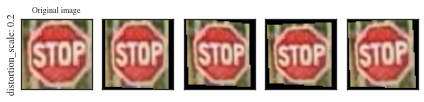

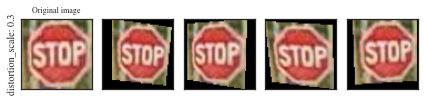

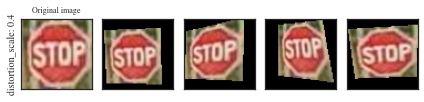

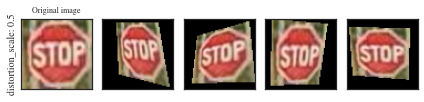

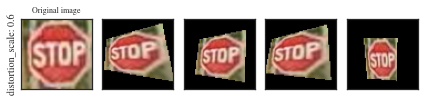

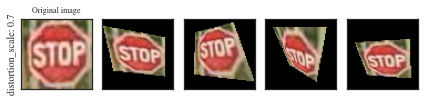

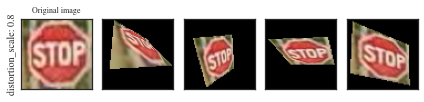

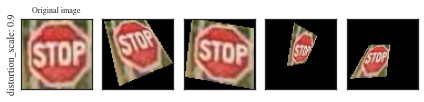

In [35]:
# code to visualize transform
plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(0)

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [img_cropped_resized] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title)

    plt.tight_layout()
    
for scale in np.arange(0.2, 1, 0.1):
    perspective_transformer = torchvision.transforms.RandomPerspective(distortion_scale=scale, p=1.0)
    perspective_imgs = [perspective_transformer(img_cropped_resized) for _ in range(4)]

    plot(perspective_imgs, row_title='distortion_scale: {}'.format(round(scale, 1)))

### Dataloaders

In [21]:
TRANSFORM_IMG = torchvision.transforms.Compose([
    torchvision.transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
    torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    torchvision.transforms.ToTensor()
])

TRANSFORM_IMG_VALIDATION = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [22]:
train_data = torchvision.datasets.ImageFolder(root='/data/shared/mtsd_v2_fully_annotated/train_cropped_signs/', transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [23]:
val_data = torchvision.datasets.ImageFolder(root='/data/shared/mtsd_v2_fully_annotated/val_cropped_signs/', transform=TRANSFORM_IMG_VALIDATION)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [24]:
import torch.nn as nn
import torchvision.models as models

In [25]:
class Normalize(nn.Module):
    def __init__(self, mean, sd, *args, **kwargs):
        super().__init__()
        self.register_buffer('mean', torch.tensor(mean)[None, :, None, None])
        self.register_buffer('sd', torch.tensor(sd)[None, :, None, None])

    def forward(self, x):
        return (x - self.mean) / self.sd

In [26]:
normalization_net = Normalize(mean, std)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 6)

model_path = '/home/nab_126/adv-patch-bench/model_weights/resnet18.pth'
if os.path.exists(model_path):
    print('loading model weights')
    model.load_state_dict(torch.load(model_path))

loading model weights


In [27]:
if torch.cuda.is_available():
    normalization_net = normalization_net.cuda()
    model = model.cuda()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
save_mode = False

In [30]:
epochs = 1000
min_valid_loss = np.inf

normalization_net.eval()

for e in range(epochs):
    train_loss = 0.0
    correct_train = 0
    model.train()
    for data, labels in train_data_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        optimizer.zero_grad()
        
        data = normalization_net(data)
        logits = model(data)
        
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).float().sum()

        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
     
    valid_loss = 0.0
    correct_val = 0
    model.eval()
    for data, labels in val_data_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        data = normalization_net(data)
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        correct_val += (preds == labels).float().sum()
        
        loss = criterion(logits, labels)
        valid_loss += loss.item()
     
    print('Epoch: {}'.format(e))
    
    train_accuracy = 100 * correct_train / len(train_data)
    val_accuracy = 100 * correct_val / len(val_data)

    print('Training Accuracy: {}'.format(train_accuracy))
    print('Validation Accuracy: {}'.format(val_accuracy))
    print()
    if min_valid_loss > valid_loss and save_mode:
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), model_path)

Epoch: 0
Training Accuracy: 95.86467742919922
Validation Accuracy: 93.77944946289062

Epoch: 1
Training Accuracy: 95.8806381225586
Validation Accuracy: 93.41815185546875

Epoch: 2
Training Accuracy: 95.84416198730469
Validation Accuracy: 94.81620788574219

Epoch: 3
Training Accuracy: 95.70966339111328
Validation Accuracy: 94.1407470703125

Epoch: 4
Training Accuracy: 95.7780532836914
Validation Accuracy: 94.9732894897461

Epoch: 5
Training Accuracy: 95.98550415039062
Validation Accuracy: 95.05183410644531

Epoch: 6
Training Accuracy: 95.84416198730469
Validation Accuracy: 94.76908111572266

Epoch: 7
Training Accuracy: 95.94902801513672
Validation Accuracy: 95.083251953125

Epoch: 8
Training Accuracy: 95.8624038696289
Validation Accuracy: 95.2403335571289

Epoch: 9
Training Accuracy: 95.94219207763672
Validation Accuracy: 95.02041625976562

Epoch: 10
Training Accuracy: 95.91939544677734
Validation Accuracy: 95.11466979980469

Epoch: 11
Training Accuracy: 95.83732604980469
Validation Acc

Epoch: 95
Training Accuracy: 96.3251724243164
Validation Accuracy: 95.2403335571289

Epoch: 96
Training Accuracy: 96.25450134277344
Validation Accuracy: 93.48098754882812

Epoch: 97
Training Accuracy: 96.24766540527344
Validation Accuracy: 95.16179656982422

Epoch: 98
Training Accuracy: 96.32061767578125
Validation Accuracy: 95.50737762451172

Epoch: 99
Training Accuracy: 96.37760925292969
Validation Accuracy: 95.22462463378906

Epoch: 100
Training Accuracy: 96.44599914550781
Validation Accuracy: 94.80049896240234

Epoch: 101
Training Accuracy: 96.29553985595703
Validation Accuracy: 94.34495544433594

Epoch: 102
Training Accuracy: 96.42320251464844
Validation Accuracy: 94.7847900390625

Epoch: 103
Training Accuracy: 96.45055389404297
Validation Accuracy: 94.83191680908203

Epoch: 104
Training Accuracy: 96.37532806396484
Validation Accuracy: 95.03612518310547

Epoch: 105
Training Accuracy: 96.50526428222656
Validation Accuracy: 93.4338607788086

Epoch: 106
Training Accuracy: 96.52122497

Epoch: 189
Training Accuracy: 96.55998229980469
Validation Accuracy: 95.083251953125

Epoch: 190
Training Accuracy: 96.73551177978516
Validation Accuracy: 95.28746032714844

Epoch: 191
Training Accuracy: 96.73779296875
Validation Accuracy: 94.92616271972656

Epoch: 192
Training Accuracy: 96.89053344726562
Validation Accuracy: 95.14608764648438

Epoch: 193
Training Accuracy: 96.70587921142578
Validation Accuracy: 94.9732894897461

Epoch: 194
Training Accuracy: 96.71043395996094
Validation Accuracy: 94.6277084350586

Epoch: 195
Training Accuracy: 96.74007415771484
Validation Accuracy: 95.14608764648438

Epoch: 196
Training Accuracy: 96.84037780761719
Validation Accuracy: 95.00470733642578

Epoch: 197
Training Accuracy: 96.74691009521484
Validation Accuracy: 95.09896087646484

Epoch: 198
Training Accuracy: 96.84949493408203
Validation Accuracy: 95.03612518310547

Epoch: 199
Training Accuracy: 96.67168426513672
Validation Accuracy: 94.10932922363281

Epoch: 200
Training Accuracy: 96.703598

Epoch: 283
Training Accuracy: 97.06378936767578
Validation Accuracy: 95.2403335571289

Epoch: 284
Training Accuracy: 97.1458511352539
Validation Accuracy: 95.22462463378906

Epoch: 285
Training Accuracy: 97.08430480957031
Validation Accuracy: 92.34998321533203

Epoch: 286
Training Accuracy: 97.07518768310547
Validation Accuracy: 95.2717514038086

Epoch: 287
Training Accuracy: 97.15497589111328
Validation Accuracy: 95.13037872314453

Epoch: 288
Training Accuracy: 97.10482025146484
Validation Accuracy: 95.19320678710938

Epoch: 289
Training Accuracy: 97.06834411621094
Validation Accuracy: 95.28746032714844

Epoch: 290
Training Accuracy: 97.09114074707031
Validation Accuracy: 93.37103271484375

Epoch: 291
Training Accuracy: 97.18917083740234
Validation Accuracy: 95.083251953125

Epoch: 292
Training Accuracy: 97.1937255859375
Validation Accuracy: 95.14608764648438

Epoch: 293
Training Accuracy: 96.99539947509766
Validation Accuracy: 95.5387954711914

Epoch: 294
Training Accuracy: 97.045547

Epoch: 377
Training Accuracy: 97.26667785644531
Validation Accuracy: 94.9418716430664

Epoch: 378
Training Accuracy: 97.2233657836914
Validation Accuracy: 94.3292465209961

Epoch: 379
Training Accuracy: 97.30998992919922
Validation Accuracy: 95.11466979980469

Epoch: 380
Training Accuracy: 97.23248291015625
Validation Accuracy: 94.81620788574219

Epoch: 381
Training Accuracy: 97.34190368652344
Validation Accuracy: 95.11466979980469

Epoch: 382
Training Accuracy: 97.39434051513672
Validation Accuracy: 95.2403335571289

Epoch: 383
Training Accuracy: 97.38294219970703
Validation Accuracy: 95.25604248046875

Epoch: 384
Training Accuracy: 97.30315399169922
Validation Accuracy: 94.92616271972656

Epoch: 385
Training Accuracy: 97.26211547851562
Validation Accuracy: 95.20891571044922

Epoch: 386
Training Accuracy: 97.21880340576172
Validation Accuracy: 95.42884063720703

Epoch: 387
Training Accuracy: 97.2416000366211
Validation Accuracy: 95.06754302978516

Epoch: 388
Training Accuracy: 97.2507

Epoch: 471
Training Accuracy: 97.46273040771484
Validation Accuracy: 94.9418716430664

Epoch: 472
Training Accuracy: 97.37154388427734
Validation Accuracy: 94.92616271972656

Epoch: 473
Training Accuracy: 97.49464416503906
Validation Accuracy: 95.16179656982422

Epoch: 474
Training Accuracy: 97.5516357421875
Validation Accuracy: 95.30316925048828

Epoch: 475
Training Accuracy: 97.48324584960938
Validation Accuracy: 94.80049896240234

Epoch: 476
Training Accuracy: 97.43081665039062
Validation Accuracy: 95.31887817382812

Epoch: 477
Training Accuracy: 97.42169189453125
Validation Accuracy: 95.17750549316406

Epoch: 478
Training Accuracy: 97.5151596069336
Validation Accuracy: 95.17750549316406

Epoch: 479
Training Accuracy: 97.45133209228516
Validation Accuracy: 94.9732894897461

Epoch: 480
Training Accuracy: 97.47640991210938
Validation Accuracy: 95.00470733642578

Epoch: 481
Training Accuracy: 97.39205932617188
Validation Accuracy: 95.30316925048828

Epoch: 482
Training Accuracy: 97.503